In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import state_fidelity, partial_trace

In [2]:
from qiskit.quantum_info import DensityMatrix, Statevector

def getDensityMatrix(circuit):
    return DensityMatrix(circuit).data

def getStatevector(circuit):
    return Statevector(circuit).data

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Create Circuit

In [35]:
def sampleCircuit(layer=1):
    circuit = QuantumCircuit(4)
    
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
    
    for i in range(layer):
        circuit.cz(0, 1)
        circuit.cz(1, 2)
        circuit.cz(2, 3)
        circuit.cz(3, 0)
        
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        
        circuit.barrier()

    return circuit

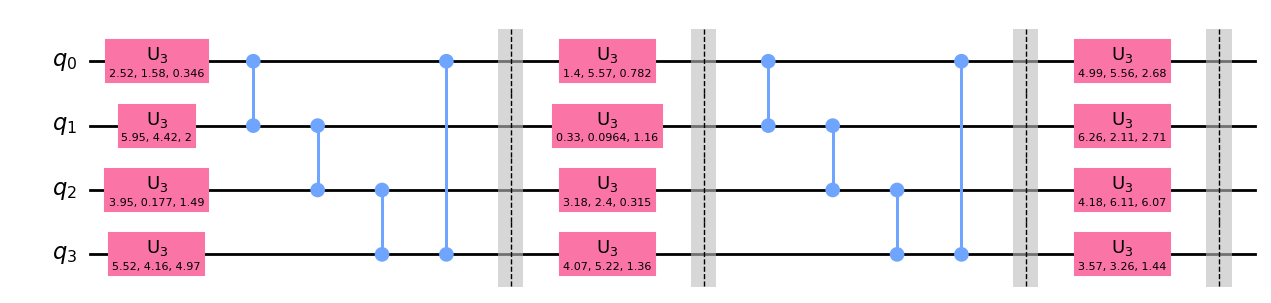

In [36]:
circuit = sampleCircuit(layer=2)
circuit.draw(output='mpl')

# 2. Measure Expressibililty

In [7]:
def P_haar(N, F):
    if F == 1:
        return 0
    return (N - 1) * ((1 - F) ** (N - 2))

In [8]:
def KL(P, Q):
    epsilon = 1e-8
    kl_divergence = 0.0
    
    for p, q in zip(P, Q):
        kl_divergence += p * np.log( (p + epsilon) / (q + epsilon) )
    
    return abs(kl_divergence)

In [34]:
def expressibility(sampler, *, bins=100, epoch=3000, layer=1):
    unit = 1 / bins
    limits = []
    probabilities = np.array([0] * bins)
    for i in range(1, bins + 1):
        limits.append(unit * i)

    for i in range(epoch):
        circuit_1 = sampler(layer=layer)
        circuit_2 = sampler(layer=layer)
        f = state_fidelity(
            getStatevector(circuit_1),
            getStatevector(circuit_2)
        )

        for j in range(bins):
            if f <= limits[j]:
                probabilities[j] += 1
                break

    pHaar_vqc = [ P_haar(2 ** 4, f - (unit/2)) / bins for f in limits]
    probabilities = [ p / epoch for p in probabilities ]

    return KL(probabilities, pHaar_vqc)

# 3. Measure Entanglement

In [10]:
def Q(circuit):
    matrix = getDensityMatrix(circuit)
    
    rou0 = partial_trace(matrix, [1, 2, 3])
    rou1 = partial_trace(matrix, [0, 2, 3])
    rou2 = partial_trace(matrix, [0, 1, 3])
    rou3 = partial_trace(matrix, [0, 1, 2])
    
    tr0 = np.abs(np.trace(rou0.data @ rou0.data))
    tr1 = np.abs(np.trace(rou1.data @ rou1.data))
    tr2 = np.abs(np.trace(rou2.data @ rou2.data))
    tr3 = np.abs(np.trace(rou3.data @ rou3.data))
    
    tr = tr0 + tr1 + tr2 + tr3
    
    return 2 * (1 - tr / 4)

In [11]:
def Ent(sampler, *, epoch=3000, layer=1):
    ent = 0
    for i in range(epoch):
        ent += Q(sampler(layer=layer))
    
    return ent / epoch

# 4. Experiment

## 4.1 dropout entanglement

In [83]:
def sampleDropoutEntanglementCircuit(layer=1):
    circuit = QuantumCircuit(4)
    
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
    
    for i in range(layer):
        if i != 0:
            circuit.cz(0, 1)
        circuit.cz(1, 2)
        if i != 1:
            circuit.cz(2, 3)
        if i != 1:
            circuit.cz(3, 0)
        
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        
        circuit.barrier()

    return circuit

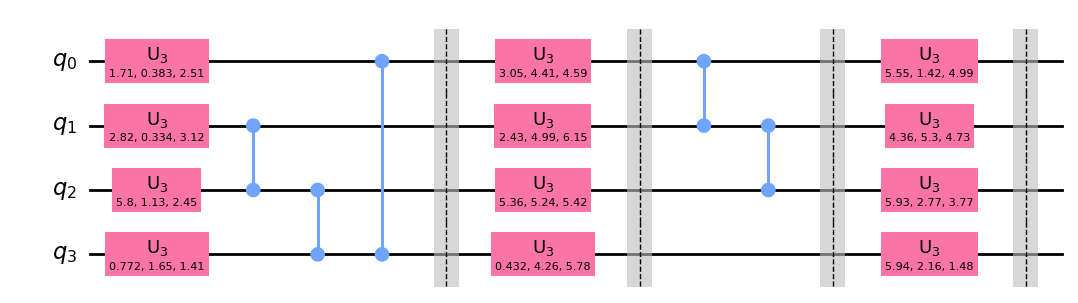

In [84]:
circuit_dropout_entanglement = sampleDropoutEntanglementCircuit(layer=2)
circuit_dropout_entanglement.draw(output='mpl')

In [87]:
print(f'expressibility(origin): {expressibility(sampleCircuit, layer=2)}')
print(f'expressibility(dropout): {expressibility(sampleDropoutEntanglementCircuit, layer=2)}')

expressibility(origin): 0.013422027241467285
expressibility(dropout): 0.022949181995651685


In [86]:
print(f'entanglement(origin): {Ent(sampleCircuit, layer=2)}')
print(f'entanglement(dropout): {Ent(sampleDropoutEntanglementCircuit, layer=2)}')

entanglement(origin): 0.5613732642111129
entanglement(dropout): 0.4930894758321403


## 4.2 dropout rotation

In [44]:
def sampleDropoutRotationCircuit(layer=1):
    circuit = QuantumCircuit(4)
    
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
#     circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
    
    for i in range(layer):
        circuit.cz(0, 1)
        circuit.cz(1, 2)
        circuit.cz(2, 3)
        circuit.cz(3, 0)
        
        circuit.barrier()
        
        if i != 0:
            circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        if i != 1:
            circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        
        circuit.barrier()

    return circuit

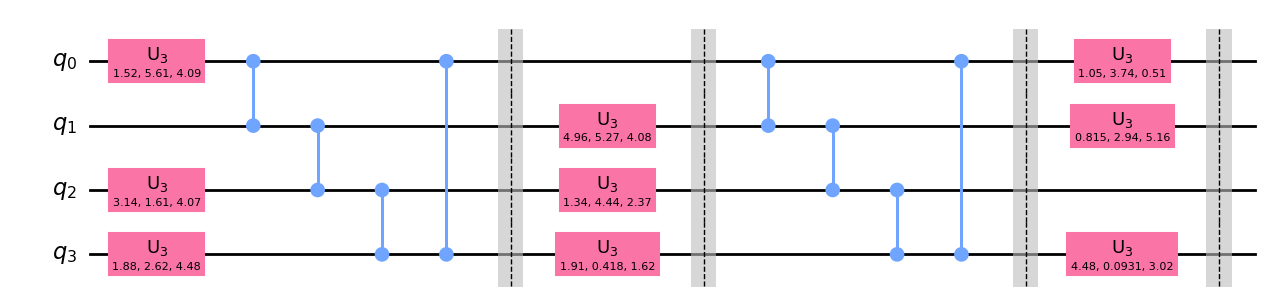

In [45]:
circuit_dropout_rotation = sampleDropoutRotationCircuit(layer=2)
circuit_dropout_rotation.draw(output='mpl')

In [69]:
print(f'expressibility(origin): {expressibility(sampleCircuit, layer=2)}')
print(f'expressibility(dropout): {expressibility(sampleDropoutRotationCircuit, layer=2)}')

expressibility(origin): 0.012661457135866678
expressibility(dropout): 0.041040382580265364


In [70]:
print(f'entanglement(origin): {Ent(sampleCircuit, layer=2)}')
print(f'entanglement(dropout): {Ent(sampleDropoutRotationCircuit, layer=2)}')

entanglement(origin): 0.5694304787804724
entanglement(dropout): 0.4313568028212006


## 4.3 bit flip noise

In [49]:
def sampleBitFlipCircuit(layer=1):
    circuit = QuantumCircuit(4)
    
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
    
    for i in range(layer):
        circuit.cz(0, 1)
        circuit.cz(1, 2)
        circuit.cz(2, 3)
        circuit.cz(3, 0)
        
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        if i == 0:
            circuit.x(0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        if i == 1:
            circuit.x(1)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        
        circuit.barrier()

    return circuit

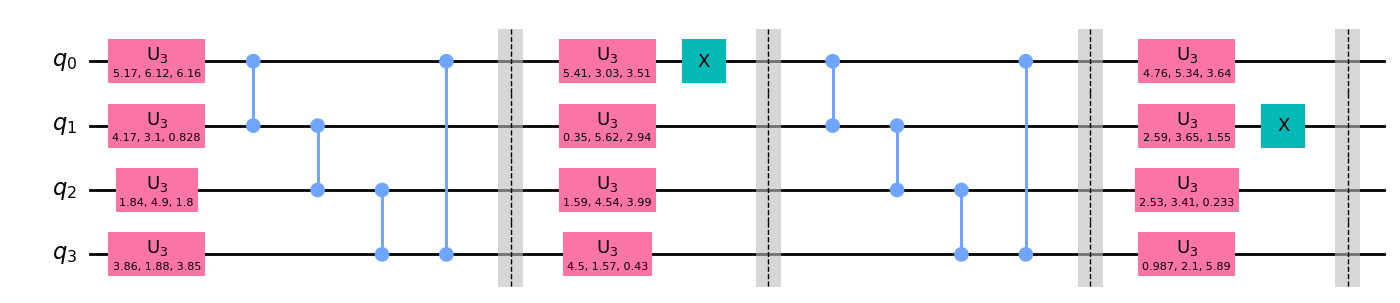

In [50]:
circuit_bit_flip = sampleBitFlipCircuit(layer=2)
circuit_bit_flip.draw(output='mpl')

In [71]:
print(f'expressibility(origin): {expressibility(sampleCircuit, layer=2)}')
print(f'expressibility(dropout): {expressibility(sampleBitFlipCircuit, layer=2)}')

expressibility(origin): 0.01645392234071952
expressibility(dropout): 0.018396250618358957


In [72]:
print(f'entanglement(origin): {Ent(sampleCircuit, layer=2)}')
print(f'entanglement(dropout): {Ent(sampleBitFlipCircuit, layer=2)}')

entanglement(origin): 0.554906015538728
entanglement(dropout): 0.567022503638356


## 4.4 phase flip noise

In [56]:
def samplePhaseFlipCircuit(layer=1):
    circuit = QuantumCircuit(4)
    
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
    
    for i in range(layer):
        circuit.cz(0, 1)
        circuit.cz(1, 2)
        circuit.cz(2, 3)
        circuit.cz(3, 0)
        
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        if i == 0:
            circuit.z(0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        if i == 1:
            circuit.z(1)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        
        circuit.barrier()

    return circuit

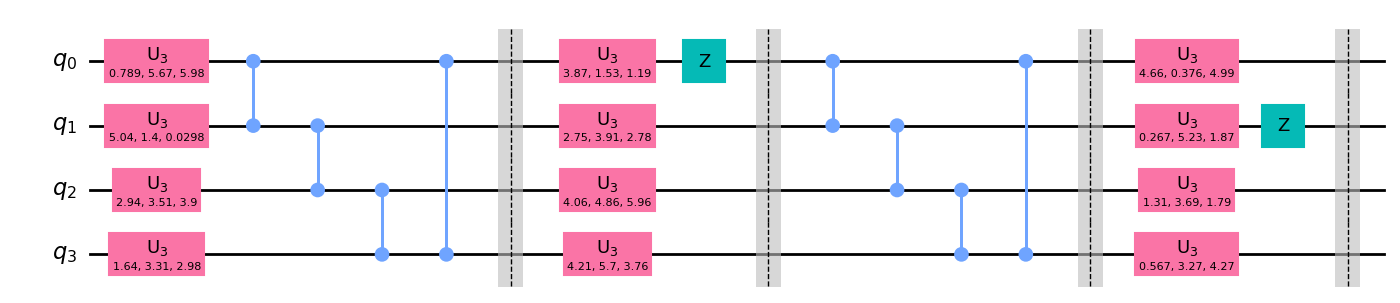

In [57]:
circuit_phase_flip = samplePhaseFlipCircuit(layer=2)
circuit_phase_flip.draw(output='mpl')

In [75]:
print(f'expressibility(origin): {expressibility(sampleCircuit, layer=2)}')
print(f'expressibility(dropout): {expressibility(samplePhaseFlipCircuit, layer=2)}')

expressibility(origin): 0.012550498004759799
expressibility(dropout): 0.015068658864572364


In [76]:
print(f'entanglement(origin): {Ent(sampleCircuit, layer=2)}')
print(f'entanglement(dropout): {Ent(samplePhaseFlipCircuit, layer=2)}')

entanglement(origin): 0.5649204373164874
entanglement(dropout): 0.5601855482189689


## 4.5 bit-phase flip noise

In [62]:
def sampleBitPhaseFlipCircuit(layer=1):
    circuit = QuantumCircuit(4)
    
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
    circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
    
    for i in range(layer):
        circuit.cz(0, 1)
        circuit.cz(1, 2)
        circuit.cz(2, 3)
        circuit.cz(3, 0)
        
        circuit.barrier()
        
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 0)
        if i == 0:
            circuit.y(0)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 1)
        if i == 1:
            circuit.y(1)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 2)
        circuit.u3(np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), np.random.uniform(0, 2 * np.pi), 3)
        
        circuit.barrier()

    return circuit

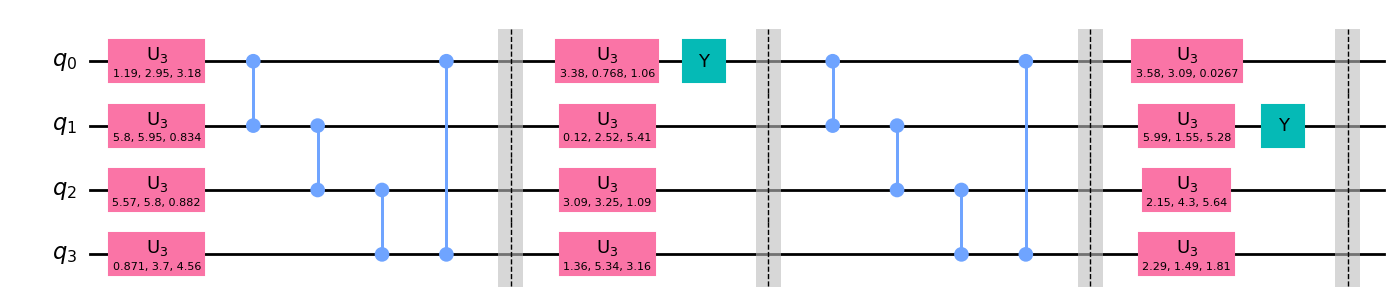

In [63]:
circuit_bit_phase_flip = sampleBitPhaseFlipCircuit(layer=2)
circuit_bit_phase_flip.draw(output='mpl')

In [77]:
print(f'expressibility(origin): {expressibility(sampleCircuit, layer=2)}')
print(f'expressibility(dropout): {expressibility(sampleBitPhaseFlipCircuit, layer=2)}')

expressibility(origin): 0.0159549217192647
expressibility(dropout): 0.01469753040143056


In [78]:
print(f'entanglement(origin): {Ent(sampleCircuit, layer=2)}')
print(f'entanglement(dropout): {Ent(sampleBitPhaseFlipCircuit, layer=2)}')

entanglement(origin): 0.5620633448524289
entanglement(dropout): 0.558936075802477


## 4.6 Dropout Layer

In [81]:
print(f'expressibility(origin): {expressibility(sampleCircuit, layer=2)}')
print(f'expressibility(dropout): {expressibility(sampleCircuit)}')

expressibility(origin): 0.017291582164296732
expressibility(dropout): 0.03829556567749537


In [82]:
print(f'entanglement(origin): {Ent(sampleCircuit, layer=2)}')
print(f'entanglement(dropout): {Ent(sampleCircuit)}')

entanglement(origin): 0.5613121832216333
entanglement(dropout): 0.37806976084358646
